<div style="background-color:gray; padding:15px; border-radius:10px; font-size:20px; color:white;">
    <h2 style="margin-bottom:10px;">xgb 모델 사용학습 1 목차</h2>
    <ol style="padding-left:20px;">
        <li>(시도 1) 수동 결측치 처리 및 인코딩 데이터 프레임으로 학습</li>
        <li>(시도 2) 타겟을 로그변환하여 비선형성을 완화한 뒤 학습</li>
        <li>(시도 3) 사용하지 않음</li>
        <li>(시도 4) 타겟인코딩 변수를 추가한 데이터 프레임으로 학습</li>
        <li>(시도 5) 높은 변수 중요도를 가지는 피쳐로만 학습</li>
        <li>(시도 6) 결측치 최빈값 대체법 -> 결측치 'Missing' 대체법</li>
        <li>(시도 7) 사용하지 않음</li>
        <li>(시도 8) 타겟인코딩한 피처 + 결측치 개수 기록한 피처</li>
        <li>(시도 9) 시도 8에서 인덱스 열 제거하고 학습</li>
        <li>(시도 10) 타겟인코딩한 피처들로만 학습</li>
    </ol>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 머신러닝 패키지
import xgboost as xgb
from sklearn.model_selection import KFold
import optuna
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error


# 그래프 한글 표시
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ce_train_df = pd.read_csv('ce_train_df')
c_train_df = pd.read_csv('c_train_df')
c_test_df = pd.read_csv('c_test_df')
ce_test_df = pd.read_csv('ce_test_df')
y_df = pd.read_csv('y_df')

In [3]:
sub = pd.read_csv('sample_submission.csv')

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 1)<br>
수동 결측치 처리 및 인코딩 데이터 프레임으로 학습
</div>

In [10]:
# 데이터프레임 인덱스 리셋 (필수)
ce_train_df = ce_train_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# 목표 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        "tree_method": "hist",  
        "device": "cuda",
        'objective': "reg:squarederror",
        'random_state': 1
    }

    # 트리개수 별도 지정 (조기 종료 기능을 위해)
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1000) 

    # KFold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    # 점수 기록 리스트
    xgb_scores = []

    # 교차검증 반복
    for train_index, val_index in kf.split(ce_train_df):
        x_train, x_val = ce_train_df.iloc[train_index], ce_train_df.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        # gpu를 사용하기 위해 Dmatrix로 변경
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # 학습
        xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

        # 예측
        y_pred = xgb_model.predict(dval)
        rmse = root_mean_squared_error(y_val, y_pred)
        xgb_scores.append(rmse)

    return np.mean(xgb_scores)

# Optuna 설정
n_trials = 100
xgb_study = optuna.create_study(direction="minimize")

# ✅ tqdm 제거 & optuna 자체 진행률 활용
xgb_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)

[I 2025-02-12 13:28:32,223] A new study created in memory with name: no-name-6343cb62-31dc-4cbc-b6b4-e0c1bef47d31
[I 2025-02-12 13:30:31,342] Trial 0 finished with value: 39.46288178928106 and parameters: {'learning_rate': 0.7499773282516324, 'max_depth': 7, 'subsample': 0.7386315452991505, 'colsample_bytree': 0.7401307264611093, 'min_child_weight': 6, 'gamma': 6.5738147719846465, 'reg_alpha': 9.346850497182913, 'reg_lambda': 9.4142140448745, 'num_boost_round': 905}. Best is trial 0 with value: 39.46288178928106.
[I 2025-02-12 13:42:14,835] Trial 1 finished with value: 47.41697931831355 and parameters: {'learning_rate': 0.7646367447325538, 'max_depth': 14, 'subsample': 0.8244594947883215, 'colsample_bytree': 0.9001654107110985, 'min_child_weight': 1, 'gamma': 3.452153284182229, 'reg_alpha': 4.7745317230601, 'reg_lambda': 9.211965885695623, 'num_boost_round': 427}. Best is trial 0 with value: 39.46288178928106.
[I 2025-02-12 13:55:02,203] Trial 2 finished with value: 55.62225560546945 a


최고의 RMSE값: 38.88513297803685
최고의 하이퍼파라미터: {'learning_rate': 0.01999207226358074, 'max_depth': 6, 'subsample': 0.720216077602895, 'colsample_bytree': 0.6101368988555378, 'min_child_weight': 7, 'gamma': 5.798319478844418, 'reg_alpha': 1.7997290362508518, 'reg_lambda': 1.7289140167633166, 'num_boost_round': 908}


C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:19:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


Feature Importances:
                   Feature  Importance
1     Weight Capacity (kg)     12343.0
0             Compartments      6206.0
2            Missing_count      4334.0
17           Waterproof_No      1932.0
15   Laptop Compartment_No      1779.0
11      Material_Polyester      1623.0
13             Size_Medium      1579.0
19          Style_Backpack      1475.0
20         Style_Messenger      1458.0
7       Brand_Under Armour      1442.0
12              Size_Large      1440.0
26              Color_Pink      1391.0
14              Size_Small      1383.0
21              Style_Tote      1330.0
8          Material_Canvas      1302.0
6               Brand_Puma      1235.0
5               Brand_Nike      1223.0
9         Material_Leather      1174.0
27               Color_Red      1173.0
10          Material_Nylon      1156.0
22             Color_Black      1148.0
24              Color_Gray      1138.0
3             Brand_Adidas      1135.0
4           Brand_Jansport      1112.0
23  

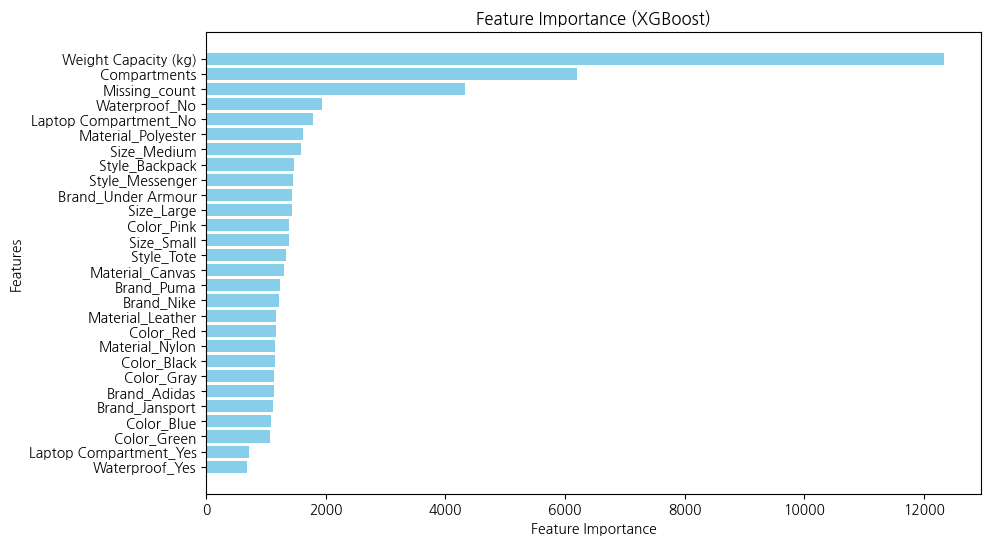

In [11]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------

# 최적의 하이퍼파라미터 가져오기
best_params = xgb_study.best_params
best_params.update({
    "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"
})

# 최적의 트리 개수 별도로 가져오기
best_num_boost_round = xgb_study.best_trial.params["num_boost_round"]

# DMatrix 변환 (학습 데이터)
dtrain = xgb.DMatrix(ce_train_df, label=y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)

# DMatrix 변환 (테스트 데이터)
dtest = xgb.DMatrix(ce_test_df)

# 예측
y_pred = final_xgb_model.predict(dtest)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

#  `xgb.train()` 모델에서는 `.feature_importances_` 대신 `get_score()` 사용
feature_importances = final_xgb_model.get_score(importance_type="weight")

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
sub_1 = sub.copy()
sub_1['Price'] = y_pred
sub_1.to_csv('sub_1.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 2) 타겟을 로그변환하여 비선형성을 완화한 뒤 학습
</div>

In [13]:
# 데이터프레임 인덱스 리셋 (필수)
ce_train_df = ce_train_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

log_y_df = np.log1p(y_df)

# 목표 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        "tree_method": "hist",  
        "device": "cuda",
        'objective': "reg:squarederror",
        'random_state': 1
    }

    # 트리개수 별도 지정 (조기 종료 기능을 위해)
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1000) 

    # KFold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    # 점수 기록 리스트
    xgb_scores = []

    # 교차검증 반복
    for train_index, val_index in kf.split(ce_train_df):
        x_train, x_val = ce_train_df.iloc[train_index], ce_train_df.iloc[val_index]
        y_train, y_val = log_y_df.iloc[train_index], log_y_df.iloc[val_index]

        # gpu를 사용하기 위해 Dmatrix로 변경
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # 학습
        xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

        # 예측
        y_pred = np.expm1(xgb_model.predict(dval))
        rmse = root_mean_squared_error(np.expm1(y_val), y_pred)
        xgb_scores.append(rmse)

    return np.mean(xgb_scores)

# Optuna 설정
n_trials = 100
xgb_study = optuna.create_study(direction="minimize")

# ✅ tqdm 제거 & optuna 자체 진행률 활용
xgb_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)

[I 2025-02-12 17:35:14,894] A new study created in memory with name: no-name-a290a7af-0ae6-40e9-9fc3-4eb68b5cbd60
[I 2025-02-12 17:36:00,893] Trial 0 finished with value: 40.423584221631074 and parameters: {'learning_rate': 0.9203857327524929, 'max_depth': 14, 'subsample': 0.682649836905318, 'colsample_bytree': 0.507878947599571, 'min_child_weight': 6, 'gamma': 2.131133593384993, 'reg_alpha': 0.5524064343111501, 'reg_lambda': 0.08608288329121971, 'num_boost_round': 736}. Best is trial 0 with value: 40.423584221631074.
[I 2025-02-12 17:36:38,862] Trial 1 finished with value: 40.42651034680972 and parameters: {'learning_rate': 0.22544770106964285, 'max_depth': 10, 'subsample': 0.5716763061013004, 'colsample_bytree': 0.9453414152962915, 'min_child_weight': 10, 'gamma': 7.552748328688601, 'reg_alpha': 0.2444746296624034, 'reg_lambda': 4.36491641460081, 'num_boost_round': 570}. Best is trial 0 with value: 40.423584221631074.
[I 2025-02-12 17:37:18,916] Trial 2 finished with value: 40.429646


최고의 RMSE값: 40.41317339743805
최고의 하이퍼파라미터: {'learning_rate': 0.0909888637216876, 'max_depth': 10, 'subsample': 0.7059178938180998, 'colsample_bytree': 0.6865498266269549, 'min_child_weight': 2, 'gamma': 0.8957685848450715, 'reg_alpha': 7.669978162507588, 'reg_lambda': 4.595728019879893, 'num_boost_round': 444}


<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 4)<br>
범주형 결측치를 'Missing' 텍스트로 대체<br>
타겟인코딩 변수를 추가한 데이터 프레임으로 학습
</div>

In [4]:
%%time

# 데이터 로드
ce_train_df3 = pd.read_csv('ce_train_df3')
ce_test_df3 = pd.read_csv('ce_test_df3')

# 데이터프레임 인덱스 리셋 (필수)
ce_train_df3 = ce_train_df3.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)


# 학습과정 로그 출력 최소화
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 목표 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        "tree_method": "hist",  
        "device": "cuda",
        'objective': "reg:squarederror",
        'random_state': 1
    }

    # 트리개수 별도 지정 (조기 종료 기능을 위해)
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1000) 

    # KFold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    # 점수 기록 리스트
    xgb_scores = []

    # 교차검증 반복
    for train_index, val_index in kf.split(ce_train_df3):
        x_train, x_val = ce_train_df3.iloc[train_index], ce_train_df3.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        # gpu를 사용하기 위해 Dmatrix로 변경
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # 학습
        xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

        # 예측
        y_pred = xgb_model.predict(dval)
        rmse = root_mean_squared_error(y_val, y_pred)
        xgb_scores.append(rmse)

    return np.mean(xgb_scores)

# Optuna 설정
n_trials = 100
xgb_study = optuna.create_study(direction="minimize")

# ✅ tqdm 제거 & optuna 자체 진행률 활용
xgb_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)


최고의 RMSE값: 27.63856658935547
최고의 하이퍼파라미터: {'learning_rate': 0.013101172939914363, 'max_depth': 8, 'subsample': 0.9674420765034683, 'colsample_bytree': 0.9218695892568626, 'min_child_weight': 1, 'gamma': 3.1013785581961226, 'reg_alpha': 0.008988234995584654, 'reg_lambda': 6.682614052427578, 'num_boost_round': 846}
CPU times: total: 5h 53min 4s
Wall time: 4h 10min 44s


C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


Feature Importances:
                             Feature  Importance
1               Weight Capacity (kg)     55313.0
35                Weight Capacity TE     45396.0
0                       Compartments     16140.0
2                      Missing_count      6529.0
10                  Material_Leather      3473.0
21          Waterproof_Missing_value      3287.0
16                Size_Missing_value      3243.0
3                       Brand_Adidas      3181.0
13                Material_Polyester      3008.0
8                 Brand_Under Armour      2902.0
28                       Color_Black      2755.0
9                    Material_Canvas      2744.0
15                       Size_Medium      2686.0
29                        Color_Blue      2673.0
33                        Color_Pink      2440.0
25                   Style_Messenger      2437.0
18  Laptop Compartment_Missing_value      2431.0
5                Brand_Missing_value      2431.0
31                       Color_Green      2394.0

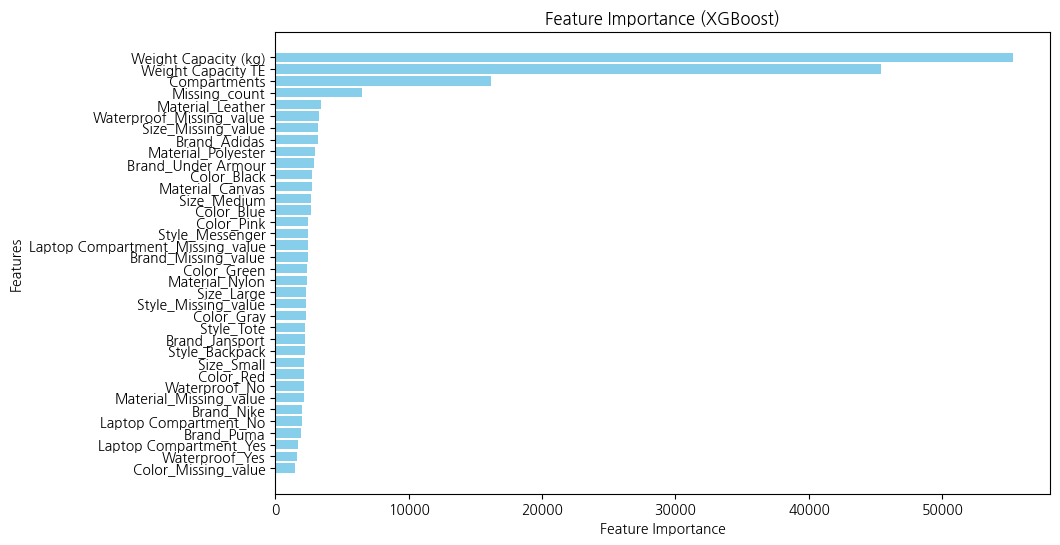

In [6]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------

# 데이터 로드
ce_train_df3 = pd.read_csv('ce_train_df3')
ce_test_df3 = pd.read_csv('ce_test_df3')

# 최적의 하이퍼파라미터 가져오기
best_params = {'learning_rate': 0.013101172939914363,
    'max_depth': 8,
    'subsample': 0.9674420765034683, 
    'colsample_bytree': 0.9218695892568626, 
    'min_child_weight': 1, 
    'gamma': 3.1013785581961226, 
    'reg_alpha': 0.008988234995584654, 
    'reg_lambda': 6.682614052427578, 
    'num_boost_round': 846}
best_params.update({
    "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"
})

# 최적의 트리 개수 별도로 가져오기
best_num_boost_round = 846

# DMatrix 변환 (학습 데이터)
dtrain = xgb.DMatrix(ce_train_df3, label=y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)

# DMatrix 변환 (테스트 데이터)
dtest = xgb.DMatrix(ce_test_df3)

# 예측
y_pred = final_xgb_model.predict(dtest)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

#  `xgb.train()` 모델에서는 `.feature_importances_` 대신 `get_score()` 사용
feature_importances = final_xgb_model.get_score(importance_type="weight")

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
sub_4 = sub.copy()
sub_4['Price'] = y_pred
sub_4.to_csv('sub_4.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 5)<br>
높은 변수 중요도를 가지는 피쳐로만 학습
</div>

In [1]:
%%time

# 데이터 로드
ce_train_df5 = pd.read_csv('ce_train_df5')
ce_test_df5 = pd.read_csv('ce_test_df5')

# 데이터프레임 인덱스 리셋 (필수)
ce_train_df5 = ce_train_df5.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# 학습과정 로그 출력 최소화
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 목표 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        "tree_method": "hist",  
        "device": "cuda",
        'objective': "reg:squarederror",
        'random_state': 1
    }

    # 트리개수 별도 지정 (조기 종료 기능을 위해)
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1000) 

    # KFold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    # 점수 기록 리스트
    xgb_scores = []

    # 교차검증 반복
    for train_index, val_index in kf.split(ce_train_df5):
        x_train, x_val = ce_train_df5.iloc[train_index], ce_train_df5.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        # gpu를 사용하기 위해 Dmatrix로 변경
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # 학습
        xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

        # 예측
        y_pred = xgb_model.predict(dval)
        rmse = root_mean_squared_error(y_val, y_pred)
        xgb_scores.append(rmse)

    return np.mean(xgb_scores)

# Optuna 설정
n_trials = 100
xgb_study = optuna.create_study(direction="minimize")

# ✅ tqdm 제거 & optuna 자체 진행률 활용
xgb_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)

NameError: name 'pd' is not defined

C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:02:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


Feature Importances:
                Feature  Importance
0  Weight Capacity (kg)    128724.0
1    Weight Capacity TE    111300.0
2          Compartments     79188.0
3         Missing_count     41449.0


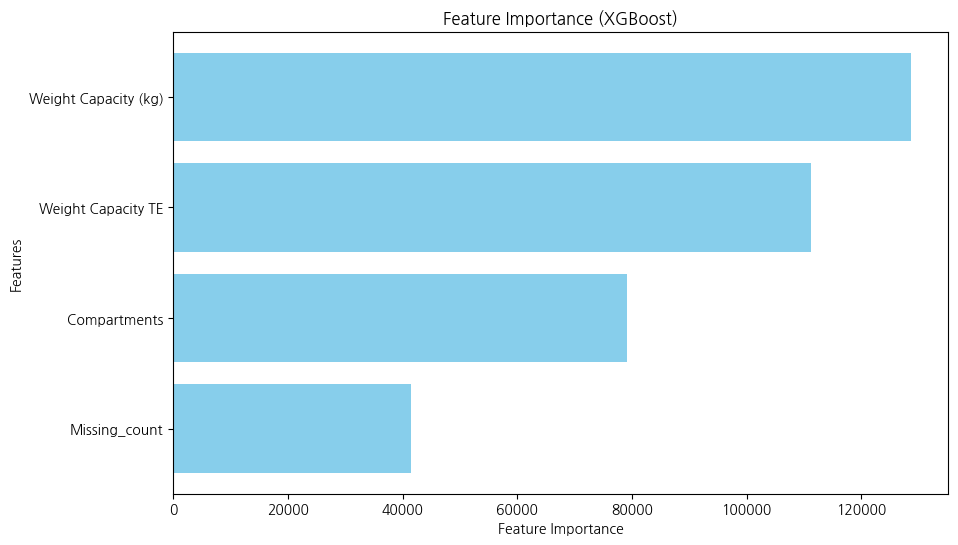

In [27]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------

# 최적의 하이퍼파라미터 가져오기
best_params = xgb_study.best_params
best_params.update({
    "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"
})

# 최적의 트리 개수 별도로 가져오기
best_num_boost_round = xgb_study.best_trial.params["num_boost_round"]

# DMatrix 변환 (학습 데이터)
dtrain = xgb.DMatrix(ce_train_df4, label=y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)

# DMatrix 변환 (테스트 데이터)
dtest = xgb.DMatrix(ce_test_df4)

# 예측
y_pred = final_xgb_model.predict(dtest)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

#  `xgb.train()` 모델에서는 `.feature_importances_` 대신 `get_score()` 사용
feature_importances = final_xgb_model.get_score(importance_type="weight")

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
sub_5 = sub.copy()
sub_5['Price'] = y_pred
sub_5.to_csv('sub_5.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 6)<br>
데이터세트1 에서<br>
결측치 최빈값대체법 -> 결측치 'Missing' 대체법
</div>

In [12]:
%%time

# 데이터 로드
ce_train_df5 = pd.read_csv('ce_train_df5')
ce_test_df5 = pd.read_csv('ce_test_df5')

# 데이터프레임 인덱스 리셋 (필수)
ce_train_df5 = ce_train_df5.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# 학습과정 로그 출력 최소화
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 목표 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        "tree_method": "hist",  
        "device": "cuda",
        'objective': "reg:squarederror",
        'random_state': 1
    }

    # 트리개수 별도 지정 (조기 종료 기능을 위해)
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1000) 

    # KFold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    # 점수 기록 리스트
    xgb_scores = []

    # 교차검증 반복
    for train_index, val_index in kf.split(ce_train_df5):
        x_train, x_val = ce_train_df5.iloc[train_index], ce_train_df5.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        # gpu를 사용하기 위해 Dmatrix로 변경
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # 학습
        xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

        # 예측
        y_pred = xgb_model.predict(dval)
        rmse = root_mean_squared_error(y_val, y_pred)
        xgb_scores.append(rmse)

    return np.mean(xgb_scores)

# Optuna 설정
n_trials = 100
xgb_study = optuna.create_study(direction="minimize")

# ✅ tqdm 제거 & optuna 자체 진행률 활용
xgb_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)


최고의 RMSE값: 38.86770401000977
최고의 하이퍼파라미터: {'learning_rate': 0.02867635711821282, 'max_depth': 7, 'subsample': 0.6606408187759735, 'colsample_bytree': 0.5182155307107215, 'min_child_weight': 9, 'gamma': 8.972480661460393, 'reg_alpha': 4.084146000949367, 'reg_lambda': 8.374571805976041, 'num_boost_round': 493}
CPU times: total: 4h 39min 44s
Wall time: 2h 57min 54s


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


Feature Importances:
                       Feature  Importance
1         Weight Capacity (kg)     10012.0
0                 Compartments      4768.0
2                Missing_count      3112.0
19       Laptop Compartment_No      1660.0
24              Style_Backpack      1568.0
23              Waterproof_Yes      1539.0
22               Waterproof_No      1490.0
17                  Size_Small      1479.0
27                  Style_Tote      1439.0
18  Laptop Compartment_Missing      1402.0
25             Style_Messenger      1396.0
15                 Size_Medium      1372.0
20      Laptop Compartment_Yes      1369.0
14                  Size_Large      1338.0
12              Material_Nylon      1290.0
9              Material_Canvas      1263.0
21          Waterproof_Missing      1252.0
16                Size_Missing      1249.0
5                Brand_Missing      1211.0
6                   Brand_Nike      1197.0
11            Material_Missing      1189.0
8           Brand_Under Armour   

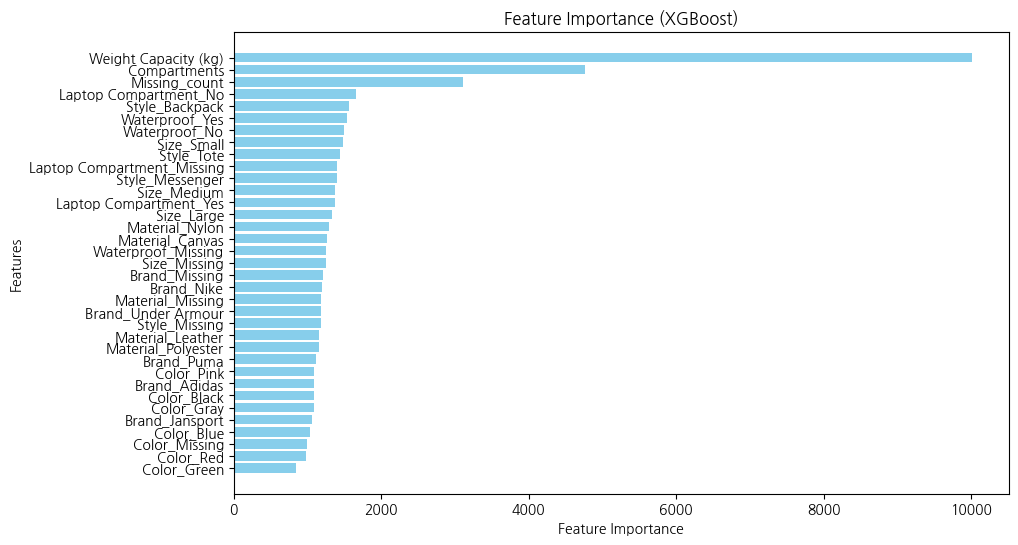

In [14]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------

# 최적의 하이퍼파라미터 가져오기
best_params = xgb_study.best_params
best_params.update({
    "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"
})

# 최적의 트리 개수 별도로 가져오기
best_num_boost_round = xgb_study.best_trial.params["num_boost_round"]

# DMatrix 변환 (학습 데이터)
dtrain = xgb.DMatrix(ce_train_df5, label=y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)

# DMatrix 변환 (테스트 데이터)
dtest = xgb.DMatrix(ce_test_df5)

# 예측
y_pred = final_xgb_model.predict(dtest)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

#  `xgb.train()` 모델에서는 `.feature_importances_` 대신 `get_score()` 사용
feature_importances = final_xgb_model.get_score(importance_type="weight")

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
sub_6 = sub.copy()
sub_6['Price'] = y_pred
sub_6.to_csv('sub_6.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 7)<br>
(사용하지 않음)
</div>

In [10]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------

# 데이터 로드
ce_train_df5 = pd.read_csv('ce_train_df5')
ce_test_df5 = pd.read_csv('ce_test_df5')

# 데이터프레임 인덱스 리셋 (필수)
ce_train_df5 = ce_train_df5.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

best_params = {
    'learning_rate': 0.01, 
    'max_depth': 20,  
    'num_boost_round': 1000,
    "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"
    }


# 최적의 트리 개수 별도로 가져오기
best_num_boost_round = 1000

# DMatrix 변환 (학습 데이터)
dtrain = xgb.DMatrix(ce_train_df5, label=y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)

# DMatrix 변환 (테스트 데이터)
dtest = xgb.DMatrix(ce_test_df5)

# 예측
y_pred = final_xgb_model.predict(dtest)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

#  `xgb.train()` 모델에서는 `.feature_importances_` 대신 `get_score()` 사용
feature_importances = final_xgb_model.get_score(importance_type="weight")

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
sub_7 = sub.copy()
sub_7['Price'] = y_pred
sub_7.to_csv('sub_7.csv', index=False)

MemoryError: 

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 8)<br>
모든 변수를 타겟인코딩한 피처로 대체<br>
+ 결측치 개수 기록한 피처 
</div>

In [5]:
# 데이터 로드
te_train_df = pd.read_csv('te_train_df')
te_test_df = pd.read_csv('te_test_df')

# 데이터프레임 인덱스 리셋 (필수)
te_train_df = te_train_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# 학습과정 로그 출력 최소화
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 목표 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 35),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        "tree_method": "hist",  
        "device": "cuda",
        'objective': "reg:squarederror",
        'random_state': 1
    }

    # 트리개수 별도 지정 (조기 종료 기능을 위해)
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1500) 

    # KFold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    # 점수 기록 리스트
    xgb_scores = []

    # 교차검증 반복
    for train_index, val_index in kf.split(te_train_df):
        x_train, x_val = te_train_df.iloc[train_index], te_train_df.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        # gpu를 사용하기 위해 Dmatrix로 변경
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # 학습
        xgb_model = xgb.train(params, dtrain,
                              num_boost_round=num_boost_round,
                              evals=[(dval, "eval")],
                              early_stopping_rounds=100,
                              verbose_eval=100)

        # 예측
        y_pred = xgb_model.predict(dval)
        rmse = root_mean_squared_error(y_val, y_pred)
        xgb_scores.append(rmse)

    return np.mean(xgb_scores)

# Optuna 설정
n_trials = 150
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)

[0]	eval-rmse:38.94176
[100]	eval-rmse:40.43038
[0]	eval-rmse:38.96046
[99]	eval-rmse:40.35397
[0]	eval-rmse:38.92554
[99]	eval-rmse:40.41957
[0]	eval-rmse:38.96938
[99]	eval-rmse:40.55235
[0]	eval-rmse:38.94608
[100]	eval-rmse:40.46372
[0]	eval-rmse:39.12305
[100]	eval-rmse:47.53009
[0]	eval-rmse:39.04091
[100]	eval-rmse:47.19413
[0]	eval-rmse:39.01350
[99]	eval-rmse:47.49249
[0]	eval-rmse:39.14755
[100]	eval-rmse:47.69904
[0]	eval-rmse:39.08235
[100]	eval-rmse:47.63137
[0]	eval-rmse:38.92733
[100]	eval-rmse:39.10765
[118]	eval-rmse:39.16791
[0]	eval-rmse:38.95501
[100]	eval-rmse:39.13441
[117]	eval-rmse:39.19239
[0]	eval-rmse:38.91905
[100]	eval-rmse:39.12632
[118]	eval-rmse:39.18724
[0]	eval-rmse:38.95457
[100]	eval-rmse:39.17906
[116]	eval-rmse:39.23785
[0]	eval-rmse:38.93623
[100]	eval-rmse:39.14407
[113]	eval-rmse:39.18882
[0]	eval-rmse:40.55548
[99]	eval-rmse:52.58818
[0]	eval-rmse:40.45183
[100]	eval-rmse:52.51465
[0]	eval-rmse:40.40357
[100]	eval-rmse:52.63673
[0]	eval-rmse:40

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:25:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


Feature Importances:
                   Feature  Importance
8  Weight Capacity (kg)_TE     16038.0
3          Compartments_TE     14117.0
7                 Color_TE     13139.0
0                 Brand_TE     13049.0
1              Material_TE     11609.0
2                  Size_TE     11125.0
6                 Style_TE     10546.0
4    Laptop Compartment_TE      9689.0
5            Waterproof_TE      9285.0
9            Missing_count      3900.0


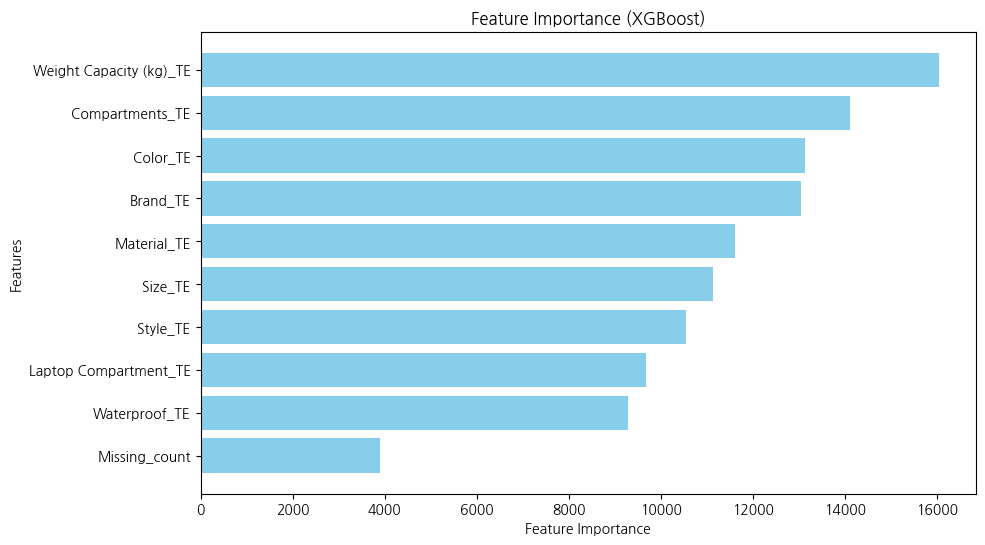

In [8]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------

# 최적의 하이퍼파라미터 가져오기
best_params = xgb_study.best_params
best_params.update({
    "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"
})

# 최적의 트리 개수 별도로 가져오기
best_num_boost_round = xgb_study.best_trial.params["num_boost_round"]

# DMatrix 변환 (학습 데이터)
dtrain = xgb.DMatrix(te_train_df, label=y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)

# DMatrix 변환 (테스트 데이터)
dtest = xgb.DMatrix(te_test_df)

# 예측
y_pred = final_xgb_model.predict(dtest)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

#  `xgb.train()` 모델에서는 `.feature_importances_` 대신 `get_score()` 사용
feature_importances = final_xgb_model.get_score(importance_type="weight")

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
sub_8 = sub.copy()
sub_8['Price'] = y_pred
sub_8.to_csv('sub_8.csv', index=False)

In [ ]:
# 아니 인덱스 넣고 학습했는데 도움이 되었다는게 어이가 없네
# 인덱스 빼고 다시한번 해봐야한다

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 9)<br>
시도 8 에서 인덱스 열 제거하고 학습
</div>

In [5]:

# -------------------------------------------   주요 파라미터 먼저 튜닝 -----------------------------------------

# 데이터 로드
te_train_df = pd.read_csv('te_train_df')
te_test_df = pd.read_csv('te_test_df')

# 학습과정 로그 출력 최소화
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 목표 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 35),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # 'gamma': trial.suggest_float('gamma', 0, 10),
        #'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        "tree_method": "hist",  
        "device": "cuda",
        'objective': "reg:squarederror",
        'random_state': 1
    }

    # 트리개수 별도 지정 (조기 종료 기능을 위해)
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1500) 

    # KFold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    # 점수 기록 리스트
    xgb_scores = []

    # 교차검증 반복
    for train_index, val_index in kf.split(te_train_df):
        x_train, x_val = te_train_df.iloc[train_index], te_train_df.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        # gpu를 사용하기 위해 Dmatrix로 변경
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # 학습
        xgb_model = xgb.train(params, dtrain,
                              num_boost_round=num_boost_round,
                              evals=[(dval, "eval")],
                              early_stopping_rounds=100,
                              verbose_eval=100)

        # 예측
        y_pred = xgb_model.predict(dval)
        rmse = root_mean_squared_error(y_val, y_pred)
        xgb_scores.append(rmse)

    return np.mean(xgb_scores)

# Optuna 설정
n_trials = 150
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)

[0]	eval-rmse:38.80786
[100]	eval-rmse:39.10133
[104]	eval-rmse:39.11474
[0]	eval-rmse:38.83472
[100]	eval-rmse:39.03779
[103]	eval-rmse:39.09186
[0]	eval-rmse:38.79817
[100]	eval-rmse:39.01420
[104]	eval-rmse:39.02172
[0]	eval-rmse:38.83544
[100]	eval-rmse:39.17377
[103]	eval-rmse:39.18427
[0]	eval-rmse:38.81303
[100]	eval-rmse:39.12014
[103]	eval-rmse:39.13217
[0]	eval-rmse:39.06538
[99]	eval-rmse:43.41309
[0]	eval-rmse:39.07103
[99]	eval-rmse:43.34346
[0]	eval-rmse:39.04757
[100]	eval-rmse:43.43470
[0]	eval-rmse:39.12545
[100]	eval-rmse:43.90708
[0]	eval-rmse:39.08253
[100]	eval-rmse:43.47587
[0]	eval-rmse:39.03447
[100]	eval-rmse:41.34103
[0]	eval-rmse:39.05558
[100]	eval-rmse:41.33319
[0]	eval-rmse:39.02605
[99]	eval-rmse:41.35261
[0]	eval-rmse:39.06955
[100]	eval-rmse:41.42198
[0]	eval-rmse:39.04592
[99]	eval-rmse:41.37498
[0]	eval-rmse:41.90539
[99]	eval-rmse:94.79582
[0]	eval-rmse:41.79697
[99]	eval-rmse:95.00448
[0]	eval-rmse:41.94589
[100]	eval-rmse:95.39902
[0]	eval-rmse:42.

[W 2025-02-24 21:29:36,112] Trial 95 failed with parameters: {'learning_rate': 0.02997151004404668, 'max_depth': 16, 'subsample': 0.8814540481938398, 'min_child_weight': 4, 'num_boost_round': 508} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_5360\1829796064.py", line 44, in objective
    xgb_model = xgb.train(params, dtrain,
                          num_boost_round=num_boost_round,
                          evals=[(dval, "eval")],
                          early_stopping_rounds=100,
                          verbose_eval=100)
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\

KeyboardInterrupt: 

In [6]:
# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)


최고의 RMSE값: 38.70744323730469
최고의 하이퍼파라미터: {'learning_rate': 0.013703799543482834, 'max_depth': 6, 'subsample': 0.9146994136721976, 'min_child_weight': 4, 'num_boost_round': 573}


In [ ]:

# -------------------------------------------   다음으로 중요한 파라미터  튜닝 -----------------------------------------

# 데이터 로드
te_train_df = pd.read_csv('te_train_df')
te_test_df = pd.read_csv('te_test_df')

# 학습과정 로그 출력 최소화
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# 학습과정 로그 출력 활성화
optuna.logging.set_verbosity(optuna.logging.INFO)

# 목표 함수 정의
def objective(trial):
    params = {
        'learning_rate': 0.013703799543482834,
        'max_depth': 6,
        'subsample': 0.9146994136721976,
        'min_child_weight': 4,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        "tree_method": "hist",  
        "device": "cuda",
        'objective': "reg:squarederror",
        'random_state': 1
    }

    # 트리개수 별도 지정 (조기 종료 기능을 위해)
    num_boost_round = 573

    # KFold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    # 점수 기록 리스트
    xgb_scores = []

    # 교차검증 반복
    for train_index, val_index in kf.split(te_train_df):
        x_train, x_val = te_train_df.iloc[train_index], te_train_df.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        # gpu를 사용하기 위해 Dmatrix로 변경
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # 학습
        xgb_model = xgb.train(params, dtrain,
                              num_boost_round=num_boost_round,
                              evals=[(dval, "eval")],
                              early_stopping_rounds=100,
                              verbose_eval= False)

        # 예측
        y_pred = xgb_model.predict(dval)
        rmse = root_mean_squared_error(y_val, y_pred)
        xgb_scores.append(rmse)

    return np.mean(xgb_scores)

# Optuna 설정
n_trials = 150
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)

[I 2025-02-24 22:05:01,477] A new study created in memory with name: no-name-8b770d81-9b5b-4bd9-9bf5-b3f323814cfe
[I 2025-02-24 22:05:45,065] Trial 0 finished with value: 38.7072135925293 and parameters: {'colsample_bytree': 0.7758404300172487, 'gamma': 2.2978090411835197, 'reg_alpha': 7.188216859275206, 'reg_lambda': 9.616085262103816}. Best is trial 0 with value: 38.7072135925293.
[I 2025-02-24 22:06:31,020] Trial 1 finished with value: 38.707376861572264 and parameters: {'colsample_bytree': 0.698348055612495, 'gamma': 1.2045057840144346, 'reg_alpha': 2.4956591917159434, 'reg_lambda': 5.160056881061288}. Best is trial 0 with value: 38.7072135925293.
[I 2025-02-24 22:07:18,160] Trial 2 finished with value: 38.7078353881836 and parameters: {'colsample_bytree': 0.5907894939099099, 'gamma': 3.972874145601434, 'reg_alpha': 7.222470035361244, 'reg_lambda': 7.513155987392581}. Best is trial 0 with value: 38.7072135925293.
[I 2025-02-24 22:08:06,640] Trial 3 finished with value: 38.707408142


최고의 RMSE값: 38.70707244873047
최고의 하이퍼파라미터: {'colsample_bytree': 0.873195834229002, 'gamma': 1.4319945252821071, 'reg_alpha': 5.208058683903292, 'reg_lambda': 9.29985066405108}


In [11]:
xgb_study.best_params

{'colsample_bytree': 0.873195834229002,
 'gamma': 1.4319945252821071,
 'reg_alpha': 5.208058683903292,
 'reg_lambda': 9.29985066405108}

Feature Importances:
                   Feature  Importance
8  Weight Capacity (kg)_TE      5766.0
7                 Color_TE      4325.0
0                 Brand_TE      4224.0
3          Compartments_TE      4196.0
1              Material_TE      3617.0
2                  Size_TE      3568.0
6                 Style_TE      3004.0
5            Waterproof_TE      2768.0
4    Laptop Compartment_TE      2605.0
9            Missing_count      1635.0


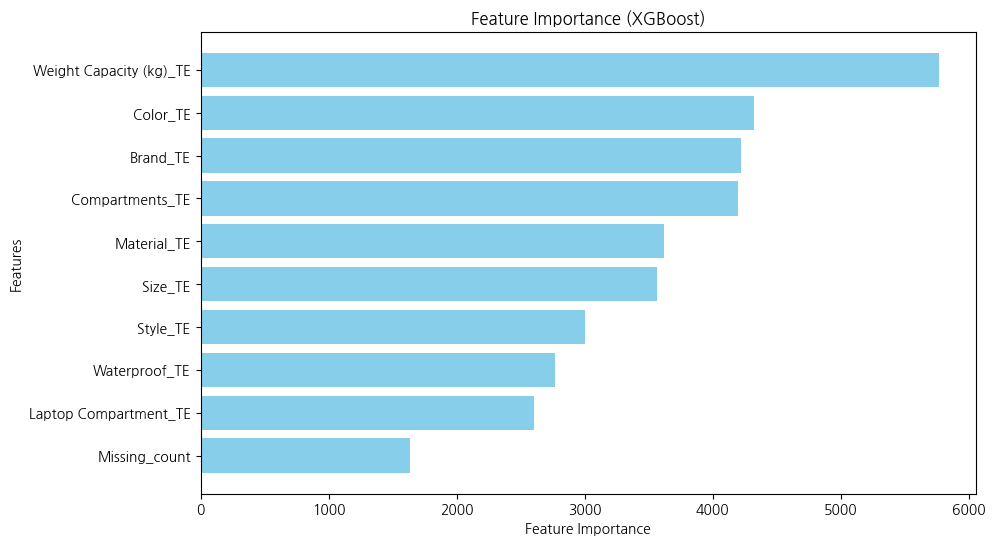

In [12]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------

# 최적의 하이퍼파라미터 가져오기
best_params = {
    'learning_rate': 0.013703799543482834,
    'max_depth': 6,
    'subsample': 0.9146994136721976,
    'min_child_weight': 4,
    'colsample_bytree': 0.873195834229002,
    'gamma': 1.4319945252821071,
    'reg_alpha': 5.208058683903292,
    'reg_lambda': 9.29985066405108,
    "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"
}

# 최적의 트리 개수 별도로 가져오기
best_num_boost_round = 573

# DMatrix 변환 (학습 데이터)
dtrain = xgb.DMatrix(te_train_df, label=y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)

# DMatrix 변환 (테스트 데이터)
dtest = xgb.DMatrix(te_test_df)

# 예측
y_pred = final_xgb_model.predict(dtest)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

#  `xgb.train()` 모델에서는 `.feature_importances_` 대신 `get_score()` 사용
feature_importances = final_xgb_model.get_score(importance_type="weight")

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
sub_9 = sub.copy()
sub_9['Price'] = y_pred
sub_9.to_csv('sub_9.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 10)<br>
Missing_count 열을 제거하고 타겟인코딩한 변수들로만 학습
</div>

In [4]:
# 데이터 로드
te_train_df = pd.read_csv('te_train_df')
te_test_df = pd.read_csv('te_test_df')

te_train_df_del_missing_count = te_train_df.drop('Missing_count', axis = 1).copy()
te_test_df_del_missing_count = te_test_df.drop('Missing_count', axis = 1).copy()

In [ ]:

# -------------------------------------------   주요 파라미터 먼저 튜닝 -----------------------------------------

# 학습과정 로그 출력 최소화
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# 학습과정 로그 출력 활성화
optuna.logging.set_verbosity(optuna.logging.INFO)

# 목표 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 35),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # 'gamma': trial.suggest_float('gamma', 0, 10),
        #'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        "tree_method": "hist",  
        "device": "cuda",
        'objective': "reg:squarederror",
        'random_state': 1
    }

    # 트리개수 별도 지정 (조기 종료 기능을 위해)
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1500) 

    # KFold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    # 점수 기록 리스트
    xgb_scores = []

    # 교차검증 반복
    for train_index, val_index in kf.split(te_train_df_del_missing_count):
        x_train, x_val = te_train_df_del_missing_count.iloc[train_index], te_train_df_del_missing_count.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        # gpu를 사용하기 위해 Dmatrix로 변경
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # 학습
        xgb_model = xgb.train(params, dtrain,
                              num_boost_round=num_boost_round,
                              evals=[(dval, "eval")],
                              early_stopping_rounds=100,
                              verbose_eval= False)

        # 예측
        y_pred = xgb_model.predict(dval)
        rmse = root_mean_squared_error(y_val, y_pred)
        xgb_scores.append(rmse)

    return np.mean(xgb_scores)

# Optuna 설정
n_trials = 100
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

# 최적 결과 출력
print("\n최고의 RMSE값:", xgb_study.best_value)
print("최고의 하이퍼파라미터:", xgb_study.best_params)

[I 2025-02-26 16:44:20,892] A new study created in memory with name: no-name-0612b2e0-df5c-458c-9f8b-7e796473c540
[I 2025-02-26 18:04:42,178] Trial 0 finished with value: 67.79236602783203 and parameters: {'learning_rate': 0.8888999818208145, 'max_depth': 35, 'subsample': 0.7661103472110986, 'min_child_weight': 7, 'num_boost_round': 1080}. Best is trial 0 with value: 67.79236602783203.
[I 2025-02-26 18:06:54,860] Trial 1 finished with value: 38.750038146972656 and parameters: {'learning_rate': 0.02456963469053623, 'max_depth': 13, 'subsample': 0.5748298420733466, 'min_child_weight': 2, 'num_boost_round': 628}. Best is trial 1 with value: 38.750038146972656.
[I 2025-02-26 18:07:42,504] Trial 2 finished with value: 38.90877990722656 and parameters: {'learning_rate': 0.12739643066873987, 'max_depth': 12, 'subsample': 0.7540218959453382, 'min_child_weight': 6, 'num_boost_round': 222}. Best is trial 1 with value: 38.750038146972656.
[I 2025-02-26 19:08:29,820] Trial 3 finished with value: 4